In [1]:
! nvidia-smi

Wed Jul 29 15:15:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%tensorflow_version 2.x

#Libraries we need to Import Initially

In [11]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set()
import tensorflow as tf
from PIL import Image

#Import the drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import os
import zipfile
local_zip = '/content/drive/My Drive/project datasets/Malaria cell classification.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()
print("Done")

Done


#Display the datasets

In [6]:

infected_dir=r'/content/Malaria cell classification/cell_images/Parasitized'
uninfected_dir=r'/content/Malaria cell classification/cell_images/Uninfected'
train_data_dir=r'/content/Malaria cell classification/cell_images'

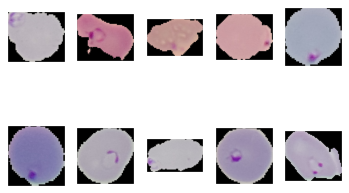

In [7]:
import cv2
import matplotlib.pyplot as plt
def main():
  j=0
  images=[]
  for i in os.listdir(infected_dir):
    if(j<=10):
      img1=cv2.imread(os.path.join(infected_dir,i),1)
      img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
      images.append(img1)
      j=j+1
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
  plt.show()
if __name__=="__main__":
  main()






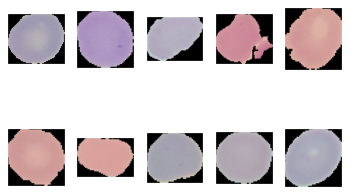

In [8]:
import cv2
import matplotlib.pyplot as plt
def main():
  j=0
  images=[]
  for i in os.listdir(uninfected_dir):
    if(j<=10):
      img1=cv2.imread(os.path.join(uninfected_dir,i),1)
      img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
      images.append(img1)
      j=j+1
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
  plt.show()
if __name__=="__main__":
  main()


#Image Augmentation and Generation

In [12]:

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=True,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,
    dtype=None,
)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128,128),
    batch_size=64,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(128,128),
    batch_size=64,
    subset='validation') # set as validation data

# model.fit_generator(
#     train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator, 
#     validation_steps = validation_generator.samples // batch_size,
#     epochs = nb_epochs)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


#Model


In [13]:
import keras
from keras.layers import Input,Dense,BatchNormalization,Conv2D,MaxPool2D,GlobalMaxPool2D,Dropout,SeparableConv2D,Dropout,GlobalAvgPool2D
from keras.models import Model

import tensorflow as tf

Using TensorFlow backend.


In [14]:
def conv2d_block(inp,filters=8,bn=True,pool=False,dropout=True):
  _=Conv2D(filters=filters,kernel_size=3,activation='relu',strides=2)(inp)
  if bn:
    _=BatchNormalization()(_)
  if pool:
    _=MaxPool2D()(_)
  if dropout:
    _=Dropout(0.2)(_)
  return _

In [15]:
def sepconv2d_block(inp,filters=8,bn=True,pool=False,dropout=True):
  _=SeparableConv2D(filters=filters,kernel_size=3,activation='relu',strides=2)(inp)
  if bn:
    _ = BatchNormalization()(_)
  if pool:

    _ = MaxPool2D()(_)
  if dropout:
    _=Dropout(0.2)(_)
  return _

In [16]:
input_layer=Input(shape=(128,128,3))
_=conv2d_block(input_layer,filters=32,bn=False)
_=conv2d_block(_,filters=32*2)
_=sepconv2d_block(_,filters=32*4)
_=sepconv2d_block(_,filters=32*8)
_=sepconv2d_block(_,filters=32*16)
_=sepconv2d_block(_,filters=32*32)
bottleneck=GlobalAvgPool2D()(_)
# for rice/building calculation
_=Dense(units=1024,activation='relu')(bottleneck)
mal_hel=Dense(units=2,activation='sigmoid',name='mal_hel')(_)

model=Model(inputs=input_layer,outputs=[mal_hel])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 63, 63, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 15, 15, 128)       8896

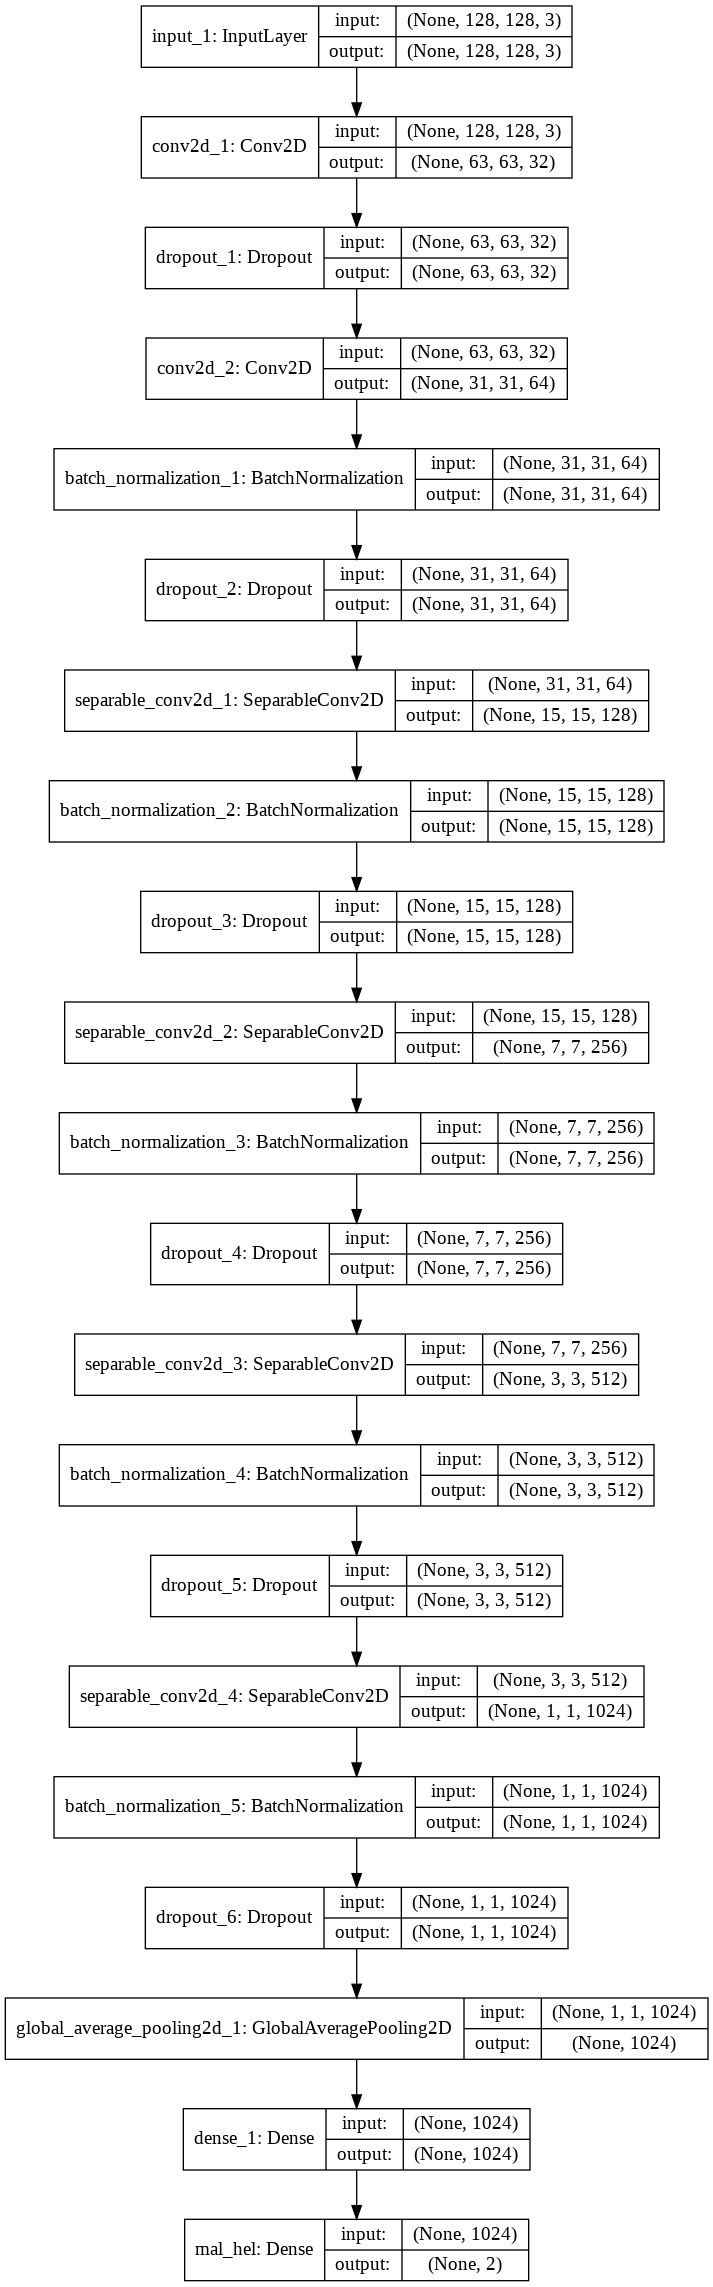

In [17]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='model.png',show_shapes=True,show_layer_names=True)

In [18]:
opt=tf.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)
# opt=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9)
bce_fn=tf.keras.losses.BinaryCrossentropy()
# cc_fn=tf.keras.losses.CategoricalCrossentropy()
model.compile(optimizer=opt,
              loss={'mal_hel':bce_fn},
              metrics={'mal_hel':"acc"})

In [19]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples //64,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples //64,
    epochs =10)

Epoch 1/10
344/344 [==============================] - 153s 444ms/step - loss: 0.4834 - acc: 0.7565 - val_loss: 0.6472 - val_acc: 0.4989
Epoch 2/10
344/344 [==============================] - 151s 439ms/step - loss: 0.2084 - acc: 0.9281 - val_loss: 0.1664 - val_acc: 0.9040
Epoch 3/10
344/344 [==============================] - 150s 437ms/step - loss: 0.2015 - acc: 0.9395 - val_loss: 0.2923 - val_acc: 0.9379
Epoch 4/10
344/344 [==============================] - 151s 438ms/step - loss: 0.1709 - acc: 0.9460 - val_loss: 0.1327 - val_acc: 0.9343
Epoch 5/10
344/344 [==============================] - 150s 435ms/step - loss: 0.1612 - acc: 0.9512 - val_loss: 0.3045 - val_acc: 0.9420
Epoch 6/10
344/344 [==============================] - 150s 435ms/step - loss: 0.1558 - acc: 0.9511 - val_loss: 0.3088 - val_acc: 0.9425
Epoch 7/10
344/344 [==============================] - 149s 434ms/step - loss: 0.1532 - acc: 0.9534 - val_loss: 0.2980 - val_acc: 0.9484
Epoch 8/10
344/344 [============================

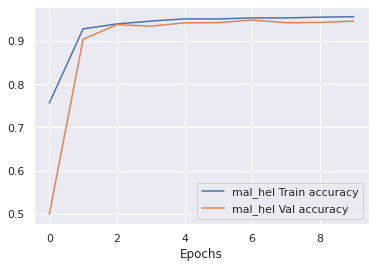

In [20]:
def  plot_train_history(history):
    fig= plt.plot( figsize=(20, 5))
    plt.plot(history.history['acc'], label='mal_hel Train accuracy')
    plt.plot(history.history['val_acc'], label='mal_hel Val accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plot_train_history(history)